In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define COP(LWT, T_OA)
COP_table = [[0,-25,-20,-15,-7,-4,-2,2,7,10,15,18,20,35],
      [30,2.13,2.34,2.55,3.15,3.36,3.47,3.69,4.93,5.22,5.99,6.29,6.49,7.98],
      [35,1.85,2.13,2.40,3.00,3.17,3.28,3.50,4.60,4.87,5.56,5.84,6.02,7.41],
      [40,1.58,1.91,2.25,2.85,2.97,3.09,3.31,4.27,4.51,5.13,5.39,5.56,6.84],
      [45,1.30,1.70,2.10,2.70,2.78,2.90,3.12,3.93,4.16,4.71,4.94,5.10,6.28],
      [50,1.49,1.49,1.95,2.55,2.59,2.71,2.93,3.60,3.81,4.28,4.49,4.64,5.71],
      [55,1.80,1.80,1.80,2.40,2.39,2.53,2.73,2.80,3.46,3.85,4.05,4.17,5.14],
      [60,2.25,2.25,2.25,2.25,2.20,2.34,2.54,2.60,3.10,3.43,3.60,3.71,4.57],
      [65,2.05,2.05,2.05,2.05,2.05,2.15,2.35,2.60,2.75,3.00,3.15,3.25,4.00]]

COP = pd.DataFrame(COP_table[1:], columns=COP_table[0]).T
COP.columns = COP.iloc[0]
COP = COP[1:]

def get_COP(LWT, T_OA):
    COP_polyfit = np.polyfit(list(COP.index), list(COP[LWT]), 3)
    COPs = np.polyval(COP_polyfit, T_OA)
    return round(COPs,5)

In [3]:
# Read hourly storage levels from terminal output
Q_stor = []
with open("data/yearly_simulations/42kWh_364.txt", 'r') as file:
    for line in file:
        index_start = line.find("level: ")
        index_end = line.find("kWh", index_start)
        if index_start != -1 and index_end != -1:
            level = float(line[index_start + len("level: "):index_end].strip())
            Q_stor.append(level)

print(f"The storage levels at every hour are:\n{[round(x,2) for x in Q_stor[:5]]}...")

The storage levels at every hour are:
[0.0, 0.11, 6.37, 12.74, 19.0]...


The T_OA at every hour are:
[-3.89, -3.33, -2.78, -3.33, -3.33]...

The COP at every hour are:
[2.3, 2.32, 2.34, 2.32, 2.32]...

The Q_load at every hour are:
[5.91, 5.77, 5.67, 5.77, 5.71]...

The c_el at every hour are:
[69.39, 64.75, 63.84, 63.31, 63.17]...

The median electricity price is: 69.12


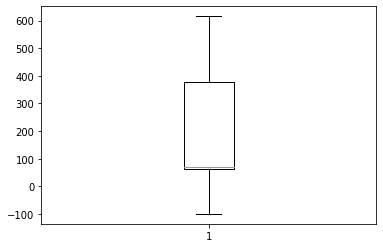

In [4]:
# Get yearly data
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df['load'] = df['House Power Required AvgKw']
df['c_el'] = df['Total Delivered Energy Cost ($/MWh)']
df['T_OA'] = df['Outside Temp F']

# Outside air
T_OA = list(df.T_OA)
T_OA = [(x-32)*5/9 for x in T_OA]
print(f"The T_OA at every hour are:\n{[round(x,2) for x in T_OA[:5]]}...")

# COP
COPs = [get_COP(60,x) for x in T_OA]
print(f"\nThe COP at every hour are:\n{[round(x,2) for x in COPs[:5]]}...")

# Load
Q_load = list(df.load)
print(f"\nThe Q_load at every hour are:\n{Q_load[:5]}...")

# Electricity prices
c_el = list(df.c_el)
print(f"\nThe c_el at every hour are:\n{[round(x,2) for x in c_el[:5]]}...")

print(f"\nThe median electricity price is: {round(np.median(c_el),2)}")
plt.boxplot(c_el)
plt.show()

In [5]:
Q_HP = []
for t in range(len(Q_stor)-2):
    Q_HP.append(Q_stor[t+1] - Q_stor[t] + Q_load[t])
Q_HP += [12, 12, 12, 12, 12, 12, 12, 0, 0, 0, 0, 0, 12, 12, 6.7, 12, 0, 0, 0, 0, 12, 12, 12, 12]
print(f"Total Q_HP: {round(sum(Q_HP),2)} kWh_th")

Q_el = [Q_HP[i]/COPs[i] for i in range(len(Q_HP))]
print(f"Total Q_el: {round(sum(Q_el),2)} kWh_el")

# Total costs with Pareto
costs = [Q_el[i]*c_el[i]/1000 for i in range(len(Q_el))]
print(f"\nTotal cost (pareto): {round(sum(costs),2)} $")

# Total costs without load shifting
costs_no_shift = [Q_load[i]/COPs[i]*c_el[i]/1000 for i in range(len(Q_el))]
print(f"Total cost (no load shifting): {round(sum(costs_no_shift),2)} $")

Total Q_HP: 28049.02 kWh_th
Total Q_el: 11577.76 kWh_el

Total cost (pareto): 710.89 $
Total cost (no load shifting): 1719.53 $
